# Split into Train / Valid / Test set

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


## Convert to PyTorch Tensor

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
data = torch.from_numpy(df.values).float() # numpy value를 float 형태의 tensor type으로 변환

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [6]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [7]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = int(data.size(0) * ratios[2])

cnts = [train_cnt, valid_cnt, test_cnt]

print(f"Train {cnts[0]} / Valid {cnts[1]} / Test {cnts[2]} ")

Train 12384 / Valid 4128 / Test 4128 


In [8]:
# Shuffle before split.

indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# Split train, valid and test set with each count.
x = list(x.split(cnts, dim=0)) # tensor.split([list]) # list index대로 쪼개준다.
y = y.split(cnts, dim=0)


for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [9]:
indices

tensor([ 8053, 10461,  5609,  ...,  8711,  2112,  2487])

# Preprocessing

In [10]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # 반드시 train data에 대해서만 fit을 진행해야 함.

StandardScaler()

In [11]:
x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,0.175491,-1.644368,1.150049,0.491456,1.625715,-0.010825,-1.411793,1.276857
12380,-0.021700,0.257663,0.313862,0.023712,0.187276,0.002598,-0.723767,1.112278
12381,0.100226,1.842689,0.340977,0.363284,-0.673926,0.015292,-0.733128,0.668417
12382,0.434144,-0.693353,0.029336,-0.064042,0.585756,-0.046951,0.773978,-1.191808
12383,0.073983,-0.693353,0.398309,-0.058593,-0.788443,-0.017201,0.296572,0.144763


# Build Model & Optimizer

In [12]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [13]:
optimizer = optim.Adam(model.parameters())

In [14]:
# figures
n_epochs = 10000
batch_size = 256
print_interval = 100

In [15]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 1000
lowest_epoch = np.inf 

In [16]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    # |x_| = (train_data_size, input_dim)
    # |y_| = (train_data_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)
    
    # You need to declare to PYTORCH to stop build the compuation graph.
    # validation 
    with torch.no_grad(): # gradient를 사용하지 말 것. # 파라미터를 하지 않음
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        # validation_size/batch_size 만큼 반복
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += loss
            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(x_)
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print(f"Epoch {i+1}: train loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, lowest_loss={lowest_loss:.5f}")
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 'state_dic()' return model weights as key-value
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last {} epochs.".format(early_stop))
            break

print("The best validation loss from epoch {} : {:4f}".format(lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 100: train loss=0.33978, valid_loss=0.31950, lowest_loss=0.31877
Epoch 200: train loss=0.32461, valid_loss=0.31505, lowest_loss=0.31403
Epoch 300: train loss=0.31861, valid_loss=0.31194, lowest_loss=0.31117
Epoch 400: train loss=0.31634, valid_loss=0.31168, lowest_loss=0.31027
Epoch 500: train loss=0.31873, valid_loss=0.31308, lowest_loss=0.30934
Epoch 600: train loss=0.31708, valid_loss=0.30922, lowest_loss=0.30890
Epoch 700: train loss=0.31791, valid_loss=0.31160, lowest_loss=0.30889
Epoch 800: train loss=0.31625, valid_loss=0.31154, lowest_loss=0.30864
Epoch 900: train loss=0.31486, valid_loss=0.30961, lowest_loss=0.30864
Epoch 1000: train loss=0.31465, valid_loss=0.30890, lowest_loss=0.30823
Epoch 1100: train loss=0.31335, valid_loss=0.30922, lowest_loss=0.30794
Epoch 1200: train loss=0.31330, valid_loss=0.30977, lowest_loss=0.30768
Epoch 1300: train loss=0.31359, valid_loss=0.30923, lowest_loss=0.30717
Epoch 1400: train loss=0.31302, valid_loss=0.30878, lowest_loss=0.30717
E

<All keys matched successfully>

# Show Loss History

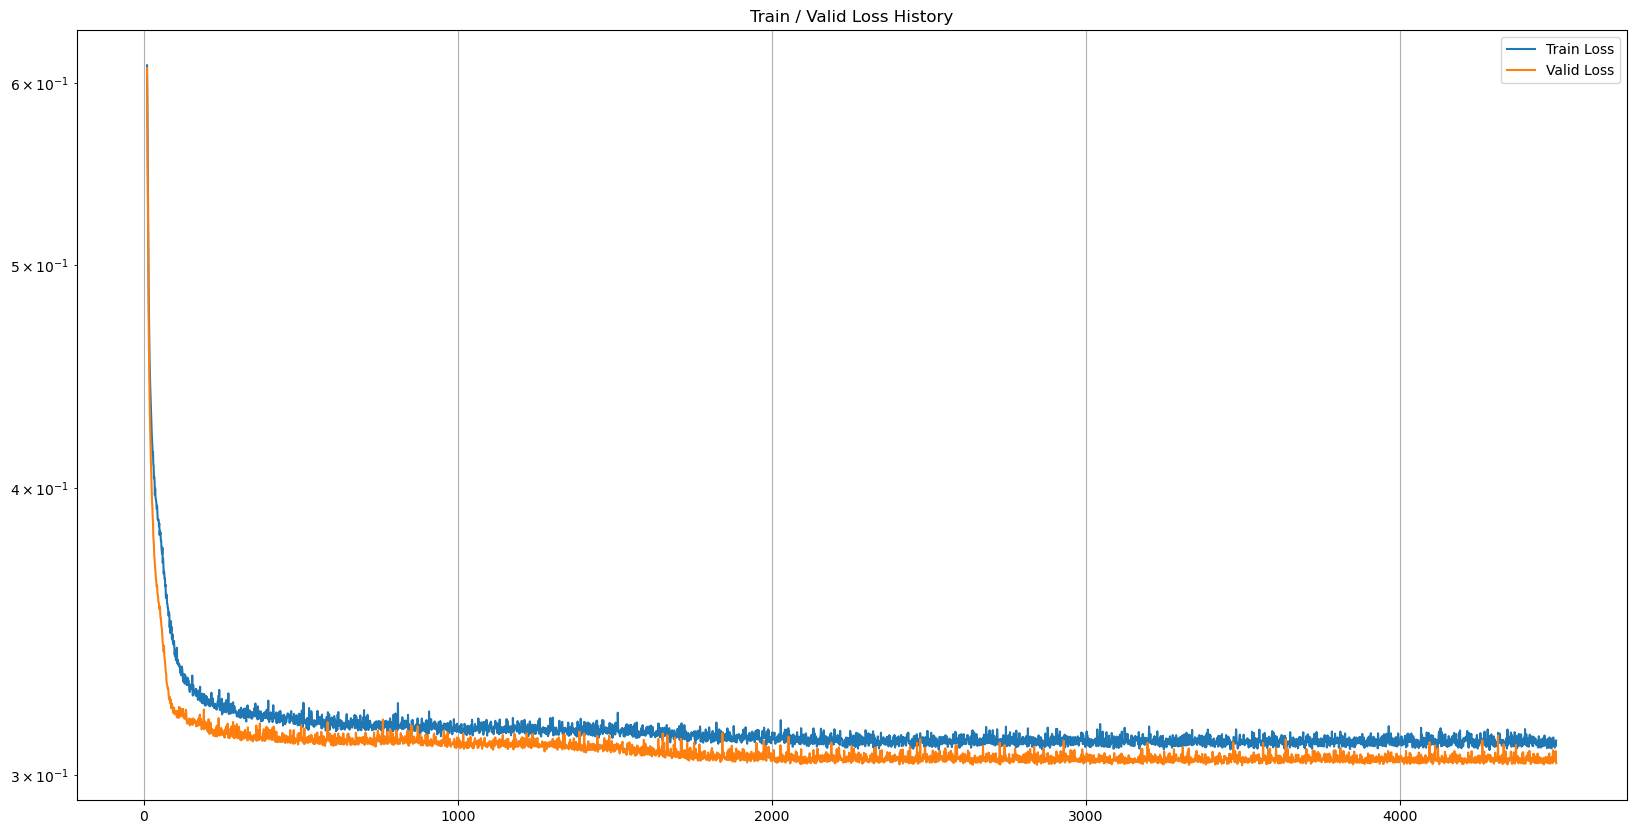

In [19]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")

plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label="Train Loss")
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label="Valid Loss")
plt.yscale('log')
plt.legend()
plt.show()


# Let's see the result!

In [24]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        test_loss += loss # Gradient is already detached.
        
        y_hat += [y_hat_i] # == y_hat.append(y_hat_i)


test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print("Train loss: {:.5f}".format(sorted_history[0][0]))
print("Valid loss: {:.5f}".format(sorted_history[0][1]))
print("Test loss: {:.5f}".format(test_loss))

Train loss: 0.30938
Valid loss: 0.30293
Test loss: 0.31809


C:\Users\kyeul\anaconda3\envs\nlp\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


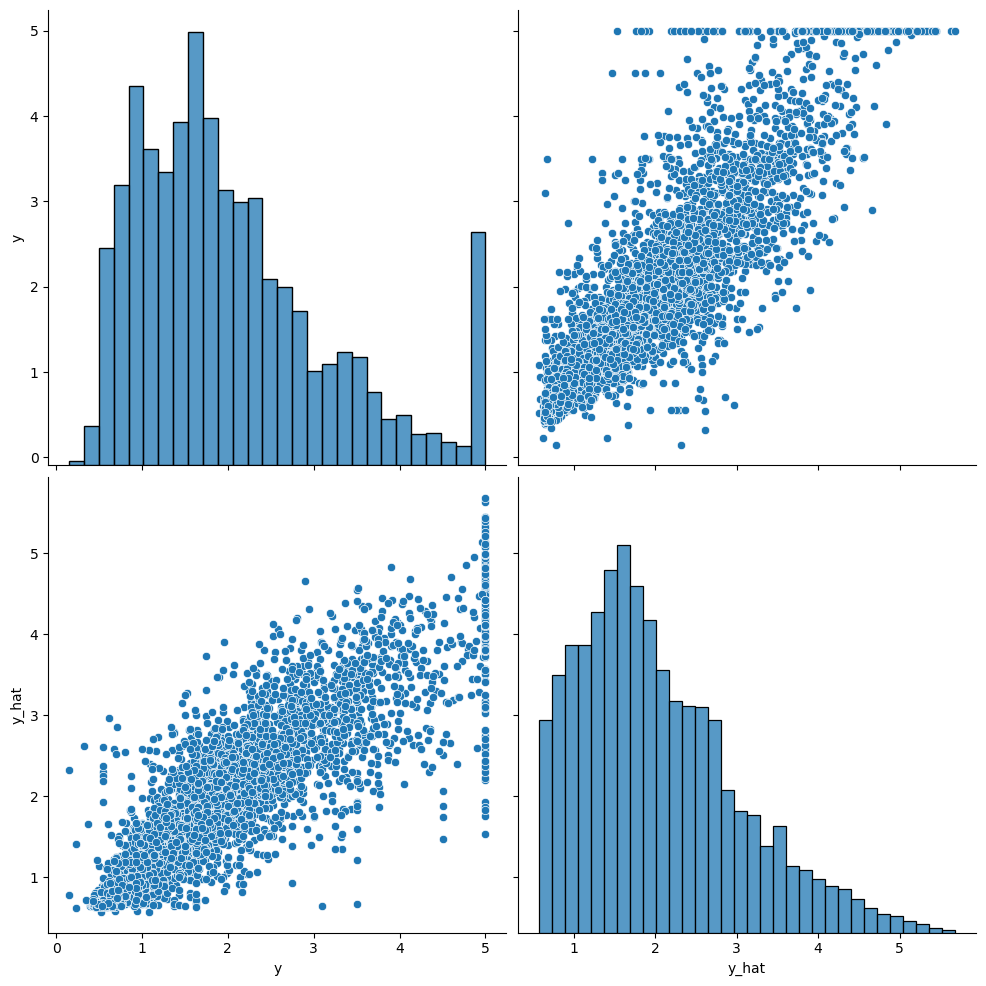

In [25]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()